In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

In [2]:
class OMATDataset(torch.utils.data.Dataset):
    def __init__(self, X_coords, X_numbers, y):
        self.X_coords = X_coords
        self.X_numbers = X_numbers
        self.y = y

    def __len__(self):
        return len(self.X_numbers)

    def __getitem__(self, idx):
       return self.X_coords[idx], self.X_numbers[idx], self.y[idx], torch.tensor([1] * len(self.y[idx]), dtype=torch.int64)

class OMATDataLoader(torch.utils.data.DataLoader):
    # Sequences are different
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

def collate_fn(batch):
    X_coords, X_numbers, labels, mask = zip(*batch)
    # print(len(X_numbers[0]), len(X_coords[0]), len(labels[0]))
    # print(len(X_numbers[1]), len(X_coords[1]), len(labels[1]))

    X_coords_t = pad_sequence([torch.tensor(c, dtype=torch.float32) for c in X_coords], batch_first=True)
    X_numbers_t = pad_sequence([torch.tensor(n, dtype=torch.int64) for n in X_numbers], batch_first=True)
    labels_t = pad_sequence([torch.tensor(y, dtype=torch.float32) for y in labels], batch_first=True)
    mask_t = pad_sequence([torch.tensor(m, dtype=torch.int64) for m in mask], batch_first=True).to(torch.bool)

    return X_coords_t, X_numbers_t, labels_t, mask_t


class SimpleTransformer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers, dim_feedforward, dropout):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim+6, num_heads, dim_feedforward, dropout,batch_first=True),
            num_layers
        )
        self.fc = nn.Linear(embedding_dim+6, 3)

    def forward(self, inputs, mask):
        # x = self.embedding(numbers+1)
        numbers, coords = inputs
        x = torch.cat([self.embedding(numbers), coords], dim=-1)
        x = self.transformer(x)
        x = self.fc(x)
        return x

In [22]:
# train_dataset = pickle.load(open("train_dataset.pkl", "rb"))
dataset = pickle.load(open("dataset.pkl", "rb"))
train_split = int(len(dataset) * 0.9)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_split, len(dataset) - train_split])
model = SimpleTransformer(200, 32, 2, 3, 128, 0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
train_dataloader = OMATDataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=collate_fn)

In [30]:
device = "cuda"
model.to(device)
for epoch in range(10):
    to_iter = tqdm(train_dataloader)
    for i, (coords, numbers, forces,mask) in enumerate(to_iter):
        to_iter.set_description(f"Loss: {np.mean(losses[-100:]):.4f}")
        optimizer.zero_grad()
        flat_mask = mask.flatten().to(device)
        forces = forces.to(device)
        label_forces = forces.reshape(-1,3)[flat_mask]
        output_forces = model((numbers.to(device),coords.to(device)), mask).reshape(-1,3)[flat_mask]
        loss = torch.mean(torch.abs(label_forces - output_forces))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/577 [00:00<?, ?it/s]<ipython-input-9-d135031045b5>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_t = pad_sequence([torch.tensor(m, dtype=torch.int64) for m in mask], batch_first=True).to(torch.bool)
Loss: 1.3626: 100%|██████████| 577/577 [00:09<00:00, 57.80it/s]


In [31]:
absolute_errors = []
test_dataloader = OMATDataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=collate_fn)
to_iter = tqdm(test_dataloader)
for i, (coords, numbers, forces,mask) in enumerate(to_iter):
    with torch.no_grad():
        to_iter.set_description(f"MAE: {np.mean(absolute_errors):.4f}")
        flat_mask = mask.flatten()
        label_forces = forces.to(device).reshape(-1,3)[flat_mask.to(device)]
        output_forces = model((numbers.to(device),coords.to(device)), mask).reshape(-1,3)[flat_mask]
        diff_vec = label_forces.flatten() - output_forces.flatten()
        absolute_errors.append(torch.mean(torch.abs(diff_vec)).item() * 3)

  0%|          | 0/65 [00:00<?, ?it/s]<ipython-input-9-d135031045b5>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_t = pad_sequence([torch.tensor(m, dtype=torch.int64) for m in mask], batch_first=True).to(torch.bool)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
MAE: 4.0329: 100%|██████████| 65/65 [00:00<00:00, 99.12it/s] 


In [29]:
# 5.97
27 / 40

0.675

In [32]:
4.03/5.9

0.6830508474576271

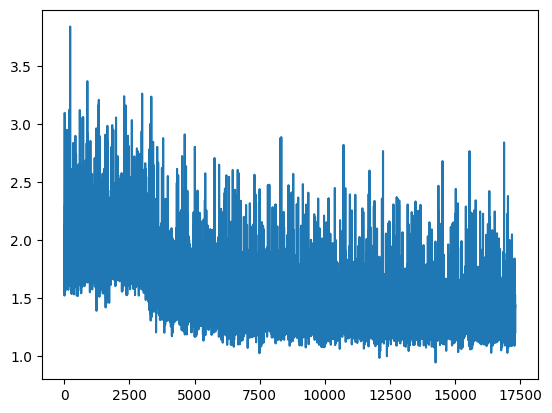

In [33]:
plt.plot(losses)